In [1]:
'''
This script is for monthly and seasonal clustering calculation and ploting:
Including Anomaly, Climatology, Plot
'''

'\nThis script is for monthly and seasonal clustering calculation and ploting:\nIncluding Anomaly, Climatology, Plot\n'

In [2]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [3]:
# return monthly average and regional longitude, latitude
def data_load(fn, start, end):
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    # How to extract the desired region? -- by calculation
    lons_xr = ds_xr['longitude'] # from -40.375W to 75.375E
    lats_xr = ds_xr['latitude'] # from 25.375N to 75.375N
    rr_xr = ds_xr['rr']
    reg_lon_xr = lons_xr[int((-12.125+40.375)*4):int((40.375+40.375)*4)] # from 12W to 40E, -12.125 TO 40.125; -40.375 to 75.375
    reg_lat_xr = lats_xr[int((32.875-25.375)*4):int((73.375-25.375)*4)] # from 33N to 73N, 33.125 to 73.125; 25.375 to 75.375
    daily_prcp_xr = rr_xr[:,int((32.875-25.375)*4):int((73.375-25.375)*4),int((-12.125+40.375)*4):int((40.375+40.375)*4)] 
    # fill in nan
    # daily_prcp = daily_prcp_xr.fillna(0)
    # first aggregate daily to monthly
    #daily_prcp = daily_prcp_xr.where(daily_prcp_xr > 2 ,0, daily_prcp_xr)
    monthly_prcp = daily_prcp_xr.resample(time='m').mean()
    # time, lat, lon
    return monthly_prcp, reg_lat_xr, reg_lon_xr

# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:]
    #### THE THRESHOLD????
    #month_anom = xr.where((month_anom>5), 0, month_anom)
    return month_anom

# extract and group each season data
def seasonal_data(anom, season):
    month_length = anom.time.dt.days_in_month # way to calculate the days in each month
    season_res = ((anom * month_length).resample(time='QS-DEC').sum(skipna=False) / 
          month_length.resample(time='QS-DEC').sum(skipna=False))
    # Using 'QS-DEC' frequency will split the data into consecutive three-month periods, anchored at December 1st.
    season_group = season_res.groupby("time.season").groups # group into seasons, use groups to read each group
    season_index = season_group[season]
    season_anom = season_res[season_index,:,:]
    #### THE THRESHOLD????
    #season_anom = xr.where((season_anom > 5),0,season_anom)
    return season_anom

# calculate normalized anomalies
# monthly climatology based on 1981 to 2010 -- refered to ECMWF
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1981", "2020")).load()
    lons_xr = dataset['longitude'] # from -40.375W to 75.375E
    lats_xr = dataset['latitude'] # from 25.375N to 75.375N
    rr_clm = ds_clm
    #reg_lon_xr = lons_xr[int((-12.125+40.375)*4):int((40.375+40.375)*4)] # from 12W to 40E, -12.125 TO 40.125; -40.375 to 75.375
    #reg_lat_xr = lats_xr[int((32.875-25.375)*4):int((73.375-25.375)*4)] # from 33N to 73N, 33.125 to 73.125; 25.375 to 75.375
    #daily_prcp_clm = rr_clm[:,int((32.875-25.375)*4):int((73.375-25.375)*4),int((-12.125+40.375)*4):int((40.375+40.375)*4)] 
    daily_prcp_clm = rr_clm
    #daily_prcp_clm = daily_prcp_clm.fillna(0) # daily prcp data from 1950 to 1980
    monthly_prcp_clm = daily_prcp_clm.resample(time='m').mean()

    gb_clm = monthly_prcp_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = monthly_prcp.groupby("time.month")
    prcp_anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized
    # important to add two times groupby
    # gb.mean: only 12 month -- average daily prcp at each month
    # prcp_anom -- each month one anomaly
    return prcp_anom

In [31]:
# NEW -- daily value return monthly average and regional longitude, latitude
def data_load_daily(fn, start, end):
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    # How to extract the desired region? -- by calculation
    lons_xr = ds_xr['longitude'] # from -40.375W to 75.375E
    lats_xr = ds_xr['latitude'] # from 25.375N to 75.375N
    rr_xr = ds_xr['rr']
    reg_lon_xr = lons_xr[int((-12.125+40.375)*4):int((40.375+40.375)*4)] # from 12W to 40E, -12.125 TO 40.125; -40.375 to 75.375
    reg_lat_xr = lats_xr[int((32.875-25.375)*4):int((73.375-25.375)*4)] # from 33N to 73N, 33.125 to 73.125; 25.375 to 75.375
    daily_prcp = rr_xr[:,int((32.875-25.375)*4):int((73.375-25.375)*4),int((-12.125+40.375)*4):int((40.375+40.375)*4)] 
    # fill in nan
    # daily_prcp = daily_prcp_xr.fillna(0)
    # first aggregate daily to monthly
    #daily_prcp = daily_prcp_xr.where(daily_prcp_xr > 2 ,0, daily_prcp_xr)
    #monthly_prcp = daily_prcp_xr.resample(time='m').mean()
    # time, lat, lon
    return daily_prcp, reg_lat_xr, reg_lon_xr

# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_daily(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:]
    #### THE THRESHOLD????
    #month_anom = xr.where((month_anom>5), 0, month_anom)
    return month_anom

# extract and group each season data
def seasonal_data_daily(anom, season):
    
    season_group = anom.groupby("time.season").groups # group into seasons, use groups to read each group
    season_index = season_group[season]
    season_anom = anom[season_index,:,:]
    #### THE THRESHOLD????
    #season_anom = xr.where((season_anom > 5),0,season_anom)
    return season_anom

# calculate normalized anomalies
# climatology based on 1981 to 2010 -- refered to ECMWF
def nor_anom_daily(dataset):
    ds_clm = dataset.sel(time=slice("1981", "2020")).load()
    lons_xr = dataset['longitude'] # from -40.375W to 75.375E
    lats_xr = dataset['latitude'] # from 25.375N to 75.375N
    rr_clm = ds_clm
    
    daily_prcp_clm = rr_clm
    #daily_prcp_clm = daily_prcp_clm.fillna(0) # daily prcp data from 1950 to 1980
    #monthly_prcp_clm = daily_prcp_clm.resample(time='m').mean()

    gb_clm = daily_prcp_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized
    # important to add two times groupby
    # gb.mean: only 12 month -- average daily prcp at each month
    # prcp_anom -- each month one anomaly
    return prcp_anom

In [5]:
fn = 'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/Prcp/EOBS/rr_ens_mean_0.25deg_reg_v24.0e.nc'
daily_prcp, reg_lon_xr, reg_lat_xr = data_load_daily(fn, '1950', '2020')

In [6]:
# calculate anomaly
prcp_anom = nor_anom_daily(daily_prcp)

In [26]:
prcp_anom.time.dt.season

<xarray.DataArray 'season' (time: 25933)>
array(['DJF', 'DJF', 'DJF', ..., 'DJF', 'DJF', 'DJF'], dtype='<U3')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [32]:
# extract and group each season data
# what if only group but not mean -- namely with all daily data available
anom_gb = seasonal_data_daily(prcp_anom, 'SON')

In [ ]:
# extract and group each month data
# what if only group but not mean -- namely with all daily data available
anom_gb = month_data_daily(prcp_anom, 1)

In [34]:
# data pre-process
np_anom_gb_reshape = np.array(anom_gb).reshape(len(anom_gb.time), 
                                         len(anom_gb.latitude)*len(anom_gb.longitude))
# infinite to zero
np_anom_gb_reshape[~np.isfinite(np_anom_gb_reshape)] = 0

# Practical question: should we do scaler here?
scaler = StandardScaler()
scaled_features = scaler.fit_transform(np_anom_gb_reshape)

In [33]:
anom_gb

<xarray.DataArray 'rr' (time: 6461, latitude: 162, longitude: 210)>
array([[[        nan,         nan,         nan, ..., -0.03044323,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.03044322,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.03044323,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.03044322,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 32.88 33.12 33.38 33.62 ... 72.62 72.88 73.12
  * longitude  (longitude) float64 -12.12 -11.88 -11.62 ... 39.62 39.88 40.12
  * time       (time) datetime64[ns] 1950-09-01 1950-09-02 ... 2020-11-30
    month      (time) int64 9 9 9 9 9 9 9 9 9 9 ... 11 11 11 11 11 11 11 11 11

In [40]:
def cluster_time_plot(start, end, index, num_cluster, name):
    x = np.arange(start, end, 1) # for winter, start from 1949
    y = index + 1
    fig, ax = plt.subplots(figsize=(5,3), dpi = 300)
    matplotlib.rcParams['xtick.labelsize'] = 8
    matplotlib.rcParams['ytick.labelsize'] = 8
    matplotlib.rcParams['axes.labelsize'] = 8
    fig = plt.gcf()
    ax.set_yticks(np.arange(1,num_cluster+1,1)) # need to change when cluster change
    ax.set_xlabel('time')
    ax.set_ylabel('cluster')
    plt.title(name, fontsize = 10)
    plt.plot(x,y,marker='o', markersize=3, linewidth=1, markerfacecolor='none')
    fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster\prcp_eobs_mon\%s.png' % name)
    # line type and y axix label
    
# visualization
# Cluster 1
# Change the Colormap
# Make the figure larger
def visualize_cluster(data, reg_lon_xr, reg_lat_xr, title1, title2):
    #data[~np.isfinite(data)] = 0
    #data = data.fillna(0)
    #data = data.where(data < 2, other=0)
    data = xr.where((data > 2),2,data) # rather 0 but a maximum value here
    matplotlib.rcParams['xtick.labelsize'] = 15
    matplotlib.rcParams['ytick.labelsize'] = 15
    matplotlib.rcParams['axes.labelsize'] = 15
    fig = plt.figure(figsize=(11,8.5), dpi = 300)
    fig = plt.gcf()
    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())

    # Add cyclic point to data
    #data=mean_anom_djf_cluster1
    data, lats = add_cyclic_point(data, coord=reg_lat_xr)

    # Make a filled contour plot
    cs=ax.contourf(lats, reg_lon_xr, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both') # (lat, lon)

    # Add coastlines
    ax.coastlines()

    # Define the xticks for longitude
    ax.set_xticks(np.arange(-12,40,5), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    plt.title(title2, fontsize = 18)
    ax.set_yticks(np.arange(33,75,5), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.tight_layout()
    # Add colorbar
    cbar = plt.colorbar(cs)
    
    fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\cluster\prcp_eobs_season\%s.png' % title1)

In [50]:
fn = 'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/Prcp/EOBS/rr_ens_mean_0.25deg_reg_v24.0e.nc'
monthly_prcp, reg_lon_xr, reg_lat_xr = data_load(fn, '1950', '2020')

In [51]:
# calculate anomaly
prcp_anom = nor_anom(monthly_prcp)

In [52]:
# extract and group each season data
anom_gb = seasonal_data(prcp_anom, 'SON')

# data pre-process
np_anom_gb_reshape = np.array(anom_gb).reshape(len(anom_gb.time), 
                                         len(anom_gb.latitude)*len(anom_gb.longitude))
# infinite to zero
np_anom_gb_reshape[~np.isfinite(np_anom_gb_reshape)] = 0

# Practical question: should we do scaler here?
scaler = StandardScaler()
scaled_features = scaler.fit_transform(np_anom_gb_reshape)

In [35]:
# K-means with s score
# sihouette coefficient:
silhouette_coefficients_vec = []
for k in range(2, 30): # start from 2
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients_vec.append(score)
#print (silhouette_coefficients_vec)


KeyboardInterrupt: 

In [ ]:
print (len(silhouette_coefficients_vec))

In [ ]:
x = np.arange(2,30,1)

fig = plt.subplots(figsize=(4,2), dpi = 200)
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 6
plt.plot(x,silhouette_coefficients_vec,'bo-')
plt.xlabel('cluster')
plt.ylabel('silhouette_coefficients')
plt.title('silhouette_coefficients vs. K');

In [ ]:
estimator_vec = KMeans(n_clusters=2)
estimator_vec.fit(scaled_features)
km_index = estimator_vec.labels_ #return labels
print (km_index)

In [ ]:
# k-means with gap statistics
# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
# Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
# Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
# Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(scaled_features, nrefs=5, maxClusters=30)


In [ ]:
fig = plt.subplots(figsize=(4,2), dpi = 200)
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 6
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

In [ ]:
estimator_vec = KMeans(n_clusters=2)
estimator_vec.fit(scaled_features)
km_index = estimator_vec.labels_ #return labels
print (km_index)

In [ ]:
# k-means with elbow plot
# Elbow Method for K means -- calculating the Within-Cluster-Sum of 
# Squared Errors (WSS) for different number of clusters (k) 
# and selecting the k for which change in WSS first starts to diminish
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(scaled_features)     # Fit data to visualizer
visualizer.show()  

In [ ]:
estimator_vec = KMeans(n_clusters=2)
estimator_vec.fit(scaled_features)
km_index = estimator_vec.labels_ #return labels
print (km_index)

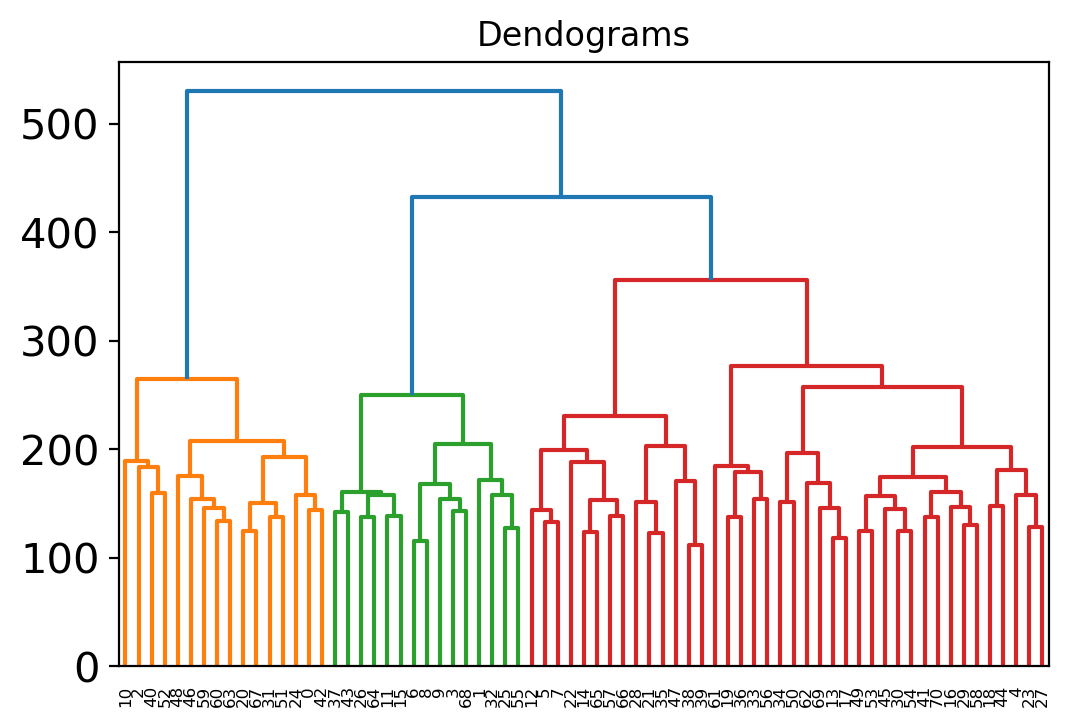

In [53]:
# hierarchy with dendrogram
plt.figure(figsize=(6, 4), dpi = 200)

plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(scaled_features, method='ward'))

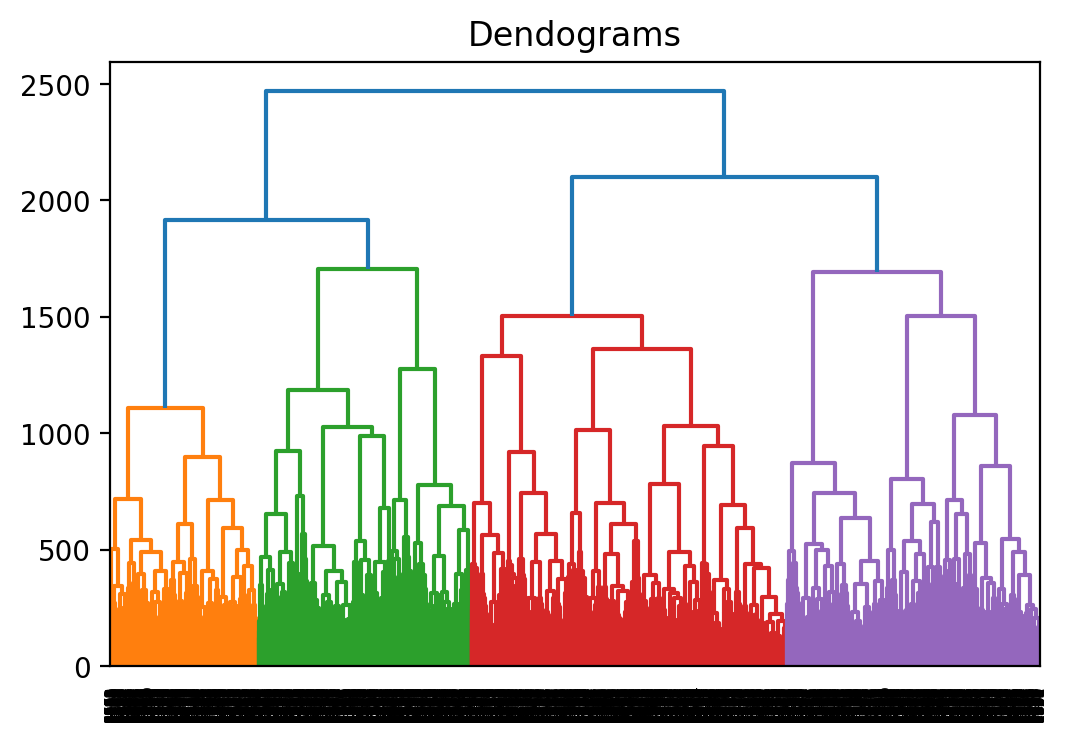

In [36]:
# hierarchy with dendrogram
plt.figure(figsize=(6, 4), dpi = 200)

plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(scaled_features, method='ward'))

In [54]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hc_index = cluster.fit_predict(scaled_features)

In [ ]:
# hierarchy with elbow plot
# Elbow Method for hierarchy
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(scaled_features)        # Fit data to visualizer
visualizer.show()  

In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
hc_index = cluster.fit_predict(scaled_features)

In [55]:
# The cluster statistics
cluster_index = hc_index

cluster1 = list(np.array(np.where(cluster_index == 0)).reshape(np.array(np.where(cluster_index == 0)).shape[1],))
cluster2 = list(np.array(np.where(cluster_index == 1)).reshape(np.array(np.where(cluster_index == 1)).shape[1],))
cluster3 = list(np.array(np.where(cluster_index == 2)).reshape(np.array(np.where(cluster_index == 2)).shape[1],))
cluster4 = list(np.array(np.where(cluster_index == 3)).reshape(np.array(np.where(cluster_index == 3)).shape[1],))

# calculate cluster average
# find the index for each cluster number
#anom_djf
anom_gb_cluster1 = anom_gb[cluster1,:,:]
anom_gb_cluster2 = anom_gb[cluster2,:,:]
anom_gb_cluster3 = anom_gb[cluster3,:,:]
anom_gb_cluster4 = anom_gb[cluster4,:,:]

# only need to calculate the mean of each cluster
mean_anom_gb_cluster1 = anom_gb_cluster1.mean('time')
mean_anom_gb_cluster2 = anom_gb_cluster2.mean('time')
mean_anom_gb_cluster3 = anom_gb_cluster3.mean('time')
mean_anom_gb_cluster4 = anom_gb_cluster4.mean('time')

# ratio of cluster
#r_cluster1 = int(len(cluster1)/(len(cluster1)+len(cluster2)+len(cluster3))*100)
#r_cluster2 = int(len(cluster2)/(len(cluster1)+len(cluster2)+len(cluster3))*100)
#r_cluster3 = int(len(cluster3)/(len(cluster1)+len(cluster2)+len(cluster3))*100)
#r_cluster4 = int(len(cluster4)/(len(cluster1)+len(cluster2)+len(cluster3))*100)

r_cluster1 = int(len(cluster1)/(len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4))*100)
r_cluster2 = int(len(cluster2)/(len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4))*100)
r_cluster3 = int(len(cluster3)/(len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4))*100)
r_cluster4 = int(len(cluster4)/(len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4))*100)

#r_cluster1 = int(len(cluster1)/(len(cluster1)+len(cluster2))*100)
#r_cluster2 = int(len(cluster2)/(len(cluster1)+len(cluster2))*100)

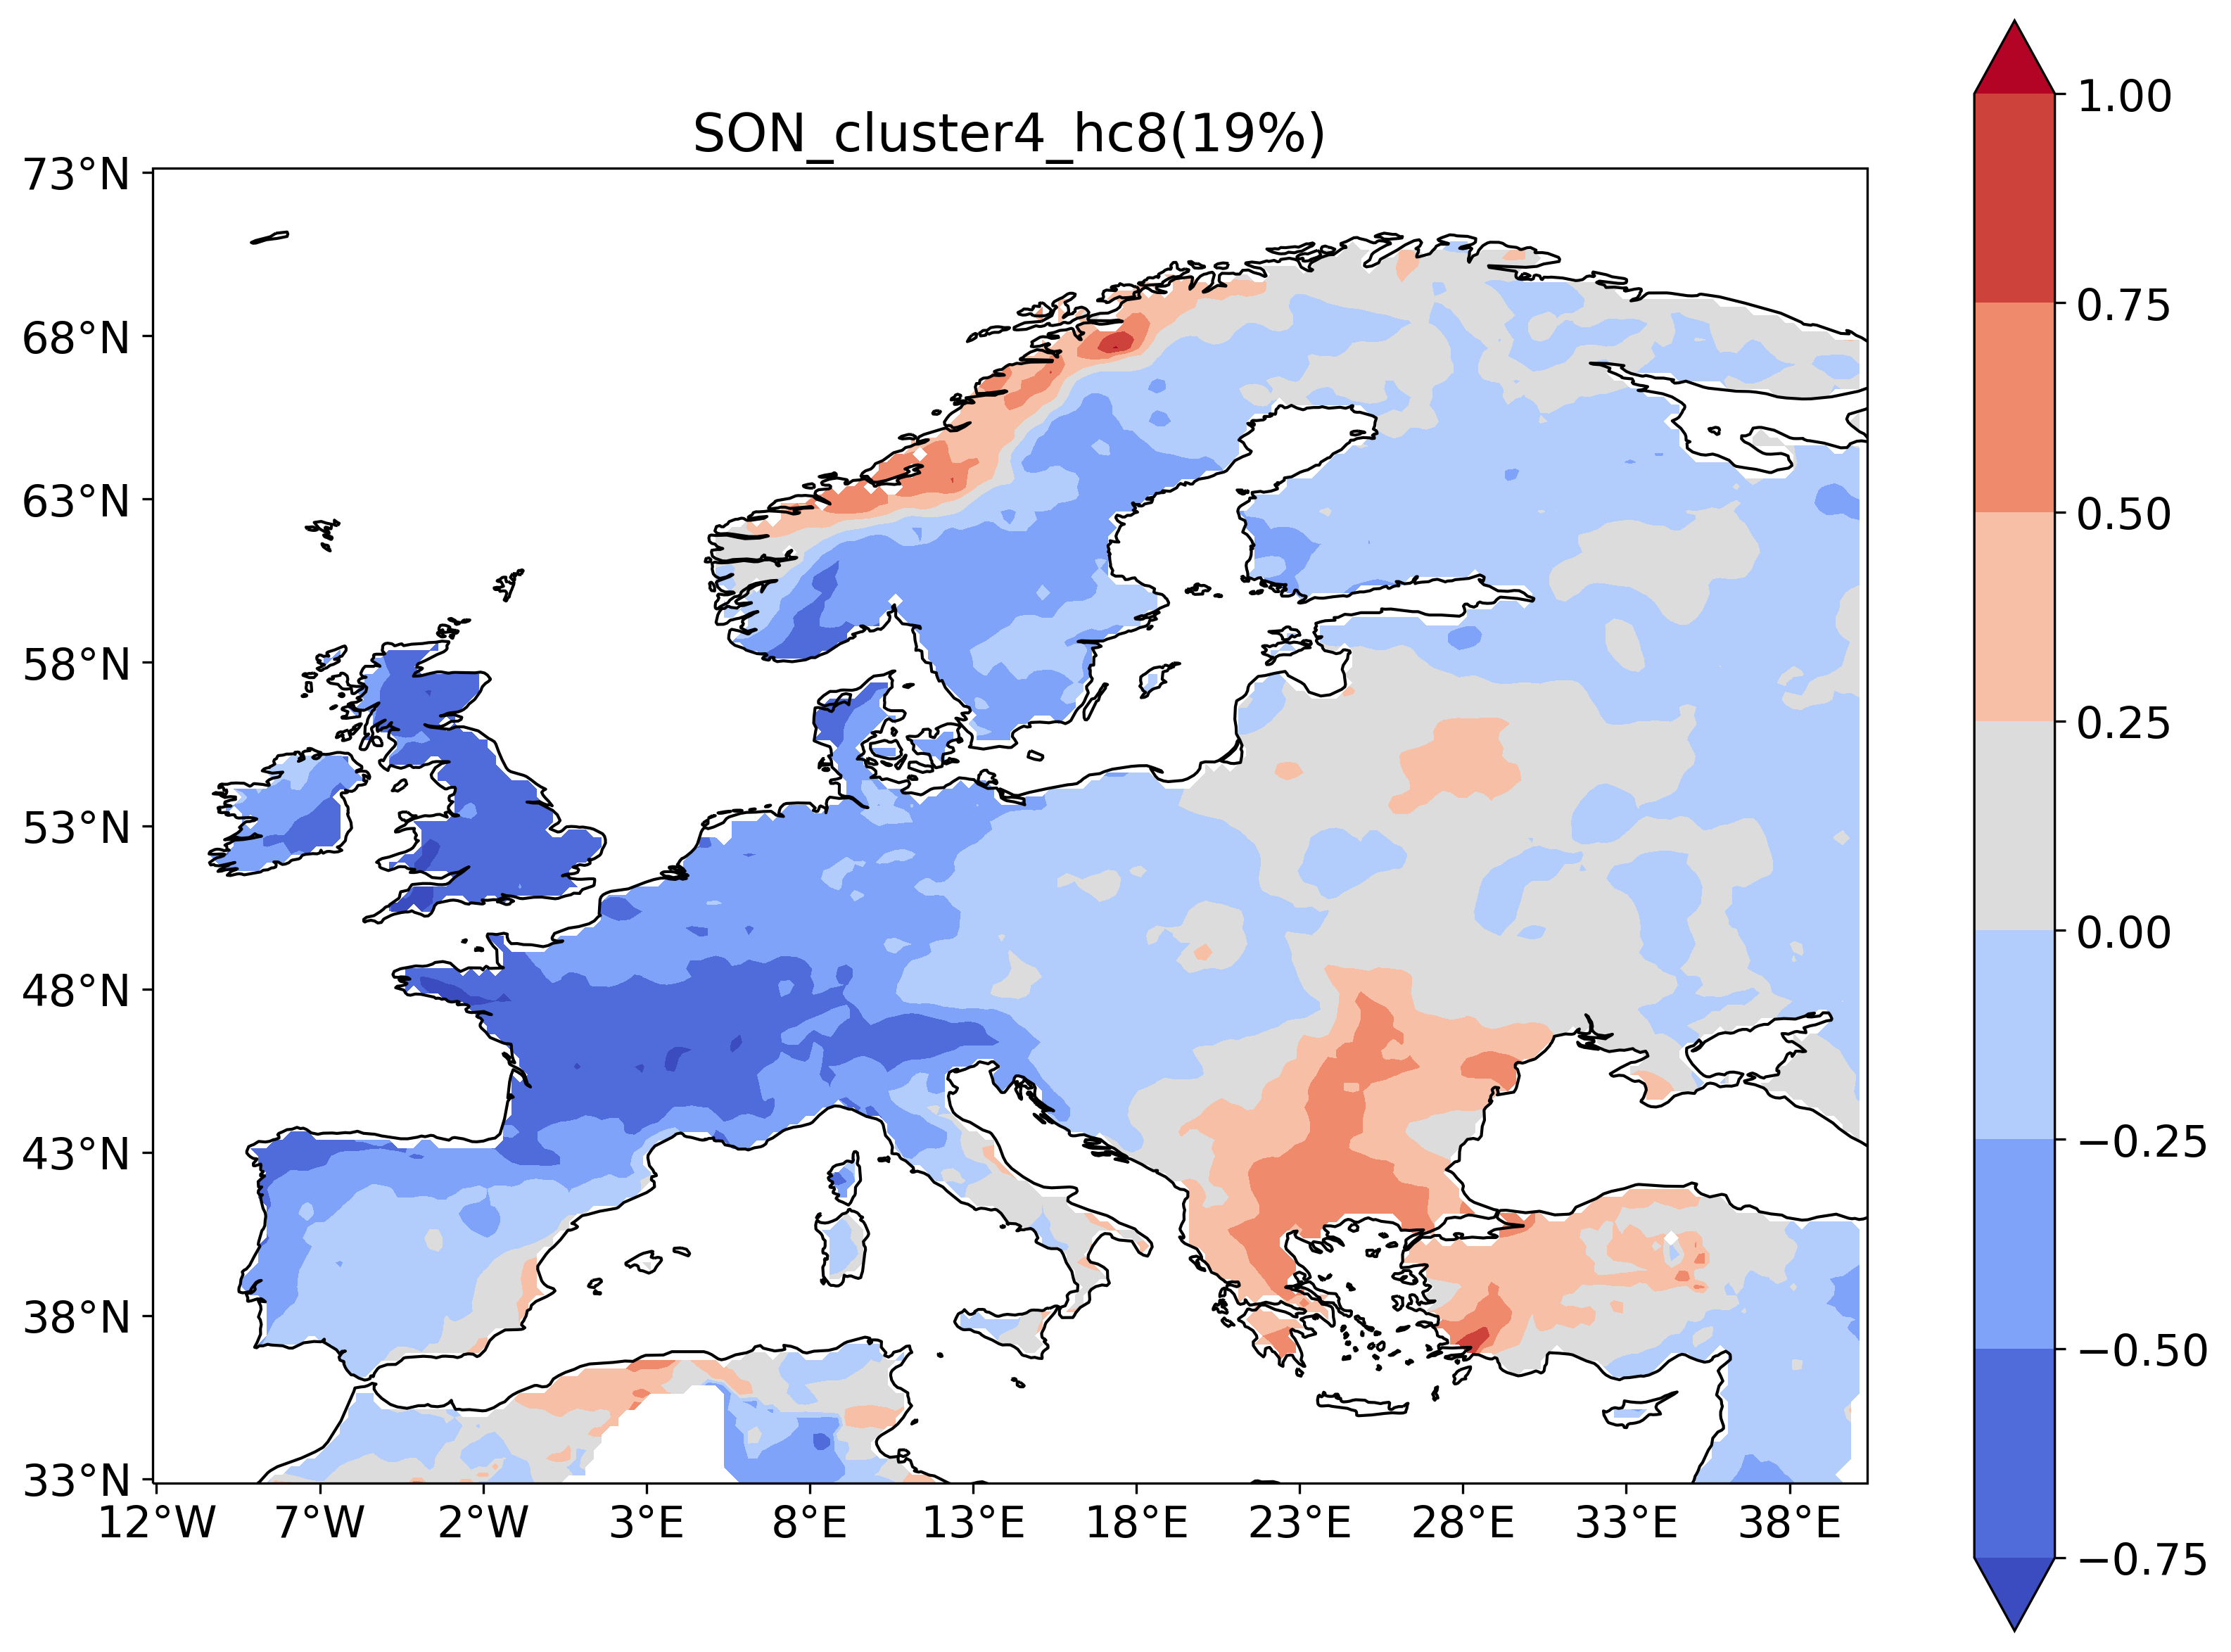

In [59]:
# visualization
title1 = 'SON_cluster4_hc8' # xx: selection method
title2 = 'SON_cluster4_hc8(%s%%)' % r_cluster4 # season/month_clusternum_method
visualize_cluster(mean_anom_gb_cluster4, reg_lon_xr,reg_lat_xr, title1, title2)